Here we use a model pretrained on the vanilla dataset and fine-tune it on a cavity dataset with and without noise, and compare its performance with a model trained on these datasets from scratch.

Import external libraries

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load cavity datasets

In [2]:
X_train = np.load('..\data\X_train_c.npy')  # population in F=1
Y_train = np.load('..\data\Y_train_c.npy')  #normalized to w_L

X_val = np.load('..\data\X_val_C.npy')  # use validation set for testing
Y_val = np.load('..\data\Y_val_C.npy')  # use validation set for testing

Normalize X data

In [3]:
Level = np.min(X_train)
Height = np.max(X_train) - np.min(X_train)

X_train = (X_train - Level) / Height
X_val = (X_val - Level) / Height

Add noise to the input data

In [4]:
noise_level = 0.002

X_train_N = X_train + np.random.normal(0, noise_level, X_train.shape)
X_val_N = X_val + np.random.normal(0, noise_level, X_val.shape)

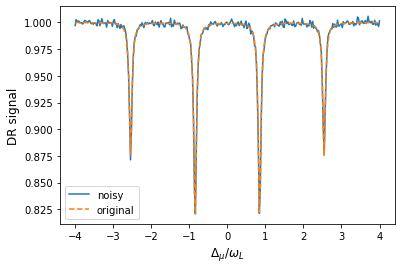

In [5]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-4,4,320), X_train_N[50], label = 'noisy')
ax.plot(np.linspace(-4,4,320), X_train[50], ls='--', label = 'original')
ax.set_xlabel(r'$\Delta_{\mu}/\omega_{L}$', fontsize=12)
ax.set_ylabel('DR signal', fontsize=12)
ax.legend(loc=0)

Shuffle data sets

In [6]:
m_train = np.random.permutation(len(X_train)) # Shuffling mask for X_train
m_test = np.random.permutation(len(X_val)) # Shuffling mask for X_test

X_train_N, Y_train = X_train_N[m_train], Y_train[m_train]
X_val_N, Y_val = X_val_N[m_test], Y_val[m_test]

Reshape X for CNN

In [7]:
X_train_N = X_train_N[:, :, np.newaxis]
X_val_N = X_val_N[:, :, np.newaxis]

Introduce training callbacks

In [8]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_loss', restore_best_weights=True) # Stop if the validation loss is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100) # Decrease the learning rate if the validation loss is not improving
cb_list = [early_stopping_cb, learning_rate_cb]

## Learning from scratch

In [9]:
model_new = keras.models.Sequential([
    keras.layers.Conv1D(kernel_size=16, activation='relu', padding='SAME', filters=32),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(kernel_size=8, activation='relu', padding='SAME', filters=64),
    keras.layers.Conv1D(kernel_size=8, activation='relu', padding='SAME', filters=64),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(kernel_size=4, activation='relu', padding='SAME', filters=128),
    keras.layers.Conv1D(kernel_size=4, activation='relu', padding='SAME', filters=128),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)
])

model_new.compile(loss="mae", optimizer=keras.optimizers.Adam(), metrics=["mae"])

In [10]:
history_new = model_new.fit(X_train_N, Y_train, epochs=2000, validation_data=(X_val_N, Y_val), batch_size=32, callbacks=cb_list, verbose=False)

8/8 [==============================] - 0s 2ms/step
max error: 0.07602342963218689
mean absolute error: 0.0034796551167288357


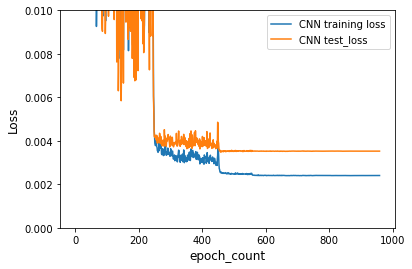

In [11]:
h_new = history_new.history

new_training_data = pd.DataFrame({"CNN training loss": h_new["loss"], "CNN test_loss": h_new["val_loss"]})
new_training_data.index.name = 'CNN Epoch'

fig_new = new_training_data.plot()
fig_new.set_xlabel(r'epoch_count', fontsize=12)
fig_new.set_ylabel(r'Loss', fontsize=12)
fig_new.set_ylim(0, 0.01)

# Calculate error
y = model_new.predict(X_val_N)
print('max error:', np.max(np.abs(y - Y_val)))
print('mean absolute error:', np.mean(np.sqrt((y - Y_val) ** 2)))

## Fine tuning

Load and train

In [12]:
pretrained_model = keras.models.load_model('model_pretrained.h5')
pretrained_model.compile(loss='mae', optimizer=keras.optimizers.Adam(),
                         metrics=['mae'])  #loss functions are given for two output neurons

Train

In [13]:
pretrained_model.compile(loss='mae', optimizer=keras.optimizers.Adam(), metrics=['mae'])
history_finetuned = pretrained_model.fit(X_train_N, Y_train, epochs=2000, validation_data=(X_val_N, Y_val), batch_size=32, callbacks=cb_list, verbose=False)

Training results

8/8 [==============================] - 0s 3ms/step
max error: 0.0639510229229927
mean absolute error: 0.0031704907514904083


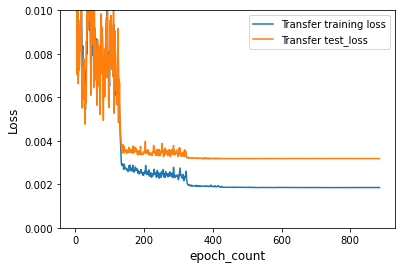

In [14]:
h_finetuned = history_finetuned.history
training_data_finetuned_cavity = pd.DataFrame(
    {"Transfer training loss": h_finetuned["loss"], "Transfer test_loss": h_finetuned["val_loss"]})
training_data_finetuned_cavity.index.name = 'Transfer Epoch'

fig_finetuned = training_data_finetuned_cavity.plot()
fig_finetuned.set_xlabel(r'epoch_count', fontsize=12)
fig_finetuned.set_ylabel(r'Loss', fontsize=12)
fig_finetuned.set_ylim(0, 0.01)

# Calculate error
y = pretrained_model.predict(X_val_N)
print('max error:', np.max(np.abs(y - Y_val)))
print('mean absolute error:', np.mean(np.sqrt((y - Y_val) ** 2)))

# Conclusions

Even though it starts at lower loss, pretrained network does not perform significantly better in terms of the final result. Both models overfit. Needs further investigation.